In [28]:
import os
import pickle
from glob import glob

import numpy as np
import pandas as pd

# ─── CONFIG ────────────────────────────────────────────────────────────────
segments_dir = "./segments_csvs"
pkls_dir     = "./pkls"          # folder where your .pkl files live (e.g. "1.pkl", "2.pkl", ...)
output_dir   = "./features_csvs"
os.makedirs(output_dir, exist_ok=True)

# ─── 1. LOAD ALL SEGMENTS ──────────────────────────────────────────────────
seg_paths = glob(os.path.join(segments_dir, "segments_*.csv"))
df_segs = pd.concat([
    pd.read_csv(p).assign(
        modality=os.path.basename(p).split("_")[1].replace(".csv", "")
    )
    for p in seg_paths
], ignore_index=True)

# ─── 2. PRELOAD SIGNALS ────────────────────────────────────────────────────
signals = {}
# We know filtered accel columns end with "_filtered"
filtered_cols = ["accelX_filtered", "accelY_filtered", "accelZ_filtered"]

for pid in sorted(df_segs["participant"].unique()):
    pkl_path = os.path.join(pkls_dir, f"{pid}.pkl")
    if not os.path.exists(pkl_path):
        print(f"⚠️ Skipping participant {pid}: no PKL at {pkl_path}")
        continue
    with open(pkl_path, "rb") as f:
        df_sig = pickle.load(f)
    # Check for 'time' and our accel columns
    if "time" not in df_sig.columns or any(c not in df_sig.columns for c in filtered_cols):
        print(f"⚠️ PKL for p{pid} missing required columns, skipping")
        continue
    signals[pid] = df_sig

#    feats["duration"] = end_t - start_t

# ─── 3. FEATURE EXTRACTION FUNCTION ────────────────────────────────────────
def extract_features_segment(df_sig, start_t, end_t):
    seg = df_sig[(df_sig["time"] >= start_t) & (df_sig["time"] <= end_t)]
    X = seg[filtered_cols].values
    feats = {}
    # time-domain stats per axis
    for i, col in enumerate(filtered_cols):
        arr = seg[col].values
        feats[f"{col}_mean"]   = arr.mean()   if len(arr)>0 else 0
        feats[f"{col}_var"]    = arr.var()    if len(arr)>0 else 0
        feats[f"{col}_energy"] = (arr**2).sum() if len(arr)>0 else 0
    # derivatives
    if X.shape[0] > 1:
        d = np.diff(X, axis=0)
        for i, col in enumerate(filtered_cols):
            darr = d[:,i]
            feats[f"{col}_deriv_mean"] = darr.mean()
            feats[f"{col}_deriv_std"]  = darr.std()
    else:
        for col in filtered_cols:
            feats[f"{col}_deriv_mean"] = 0
            feats[f"{col}_deriv_std"]  = 0
    # SMA
    feats["SMA"] = np.abs(X).sum()
    # inter-axis correlations
    if X.shape[0] > 1:
        feats["corr_xy"] = np.corrcoef(X[:,0], X[:,1])[0,1]
        feats["corr_xz"] = np.corrcoef(X[:,0], X[:,2])[0,1]
        feats["corr_yz"] = np.corrcoef(X[:,1], X[:,2])[0,1]
    else:
        feats.update({"corr_xy":0, "corr_xz":0, "corr_yz":0})
    # duration
    return feats

# ─── 4. EXTRACT FEATURES FOR EVERY EVENT ──────────────────────────────────
records = []
for _, row in df_segs.iterrows():
    pid = row["participant"]
    if pid not in signals:
        continue  # no signal available

    df_sig = signals[pid]
    feats = extract_features_segment(
        df_sig,
        start_t = row["start_time"],
        end_t   = row["end_time"]
    )
    # annotate context
    feats.update({
        "modality":    row["modality"],
        "video_id":    row["video_id"],
        "segment":     row["segment"],
        "participant": pid,
        "label":       row["label"]
    })
    records.append(feats)

# ─── 5. SAVE FEATURES DATASET ─────────────────────────────────────────────
df_features = pd.DataFrame(records)
out_path = os.path.join(output_dir, "features_dataset_without_duration.csv")
df_features.to_csv(out_path, index=False)
print(f"✅ Extracted features for {len(df_features)} segments → {out_path}")


⚠️ Skipping participant 38: no PKL at ./pkls/38.pkl
⚠️ Skipping participant 39: no PKL at ./pkls/39.pkl
✅ Extracted features for 461879 segments → ./features_csvs/features_dataset_without_duration.csv


In [7]:
# 1️⃣ How many segments do we have?
print("Total segment rows:", len(df_segs))

# 2️⃣ Which participants appear in the segment list?
segs_pids = set(df_segs["participant"].unique())
print("Participants in df_segs:", sorted(segs_pids))

# 3️⃣ Which PKLs actually loaded into `signals`?
print("Signals loaded for participants:", sorted(signals.keys()))

# 4️⃣ Intersection
print("Overlap PIDs:", sorted(segs_pids & set(signals.keys())))

# 5️⃣ Peek at the first few segment rows
print(df_segs.head())


Total segment rows: 37073
Participants in df_segs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Signals loaded for participants: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
Overlap PIDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
  modality video_id segment  participant  start_frame  end_frame  start_time  \
0       no     vid2    seg7            1            0        460        0.00   
1       no     vid2    seg7            1          461        693       18.44   
2       no     vid2    seg7            1          694       1025       27.76   
3       no     vid2   

In [8]:
import pickle

# 1) Pick a sample participant that you know has both segments and a PKL
sample_pid = next(iter(signals.keys()))
print("Sample participant:", sample_pid)

df_sig = signals[sample_pid]
print("Signal columns:", df_sig.columns.tolist())
print(df_sig.head(), "\n")

# 2) Inspect the first segment in df_segs
row = df_segs.iloc[0]
print("First segment record:", row.to_dict())

# Try slicing that segment from the signal
seg = df_sig[(df_sig["time"] >= row["start_time"]) & (df_sig["time"] <= row["end_time"])]
print("Segment slice shape:", seg.shape)
print(seg.head())


Sample participant: 1
Signal columns: ['time', 'accelX', 'accelY', 'accelZ', 'gyrX', 'gyrY', 'gyrZ', 'magX', 'magY', 'magZ', 'rotA', 'rotB', 'rotC', 'rotD', 'rssi', 'accelX_filtered', 'accelY_filtered', 'accelZ_filtered']
   time    accelX    accelY    accelZ      gyrX      gyrY      gyrZ      magX  \
0  0.00  0.097168 -0.936035  0.341797 -0.093460  4.758835  1.167297 -8.850006   
1  0.02  0.096243 -0.943179  0.360274  0.298450  2.418618  0.963311 -9.094746   
2  0.04  0.088328 -0.940558  0.349789 -1.012200  4.580548  0.038147 -8.163165   
3  0.06  0.087428 -0.946263  0.346705 -2.125288  2.940630 -0.000402 -8.771064   
4  0.08  0.086225 -0.955509  0.343894 -2.346375  3.509409 -0.356786 -9.361772   

        magY       magZ      rotA      rotB      rotC      rotD  rssi  \
0  68.099991  20.249985  0.819246 -0.570056 -0.014040 -0.014040 -86.0   
1  68.344731  20.249985  0.819336 -0.569927 -0.013469 -0.013469 -79.0   
2  67.476306  20.423670  0.819252 -0.570040 -0.012890 -0.012890 -76.5   

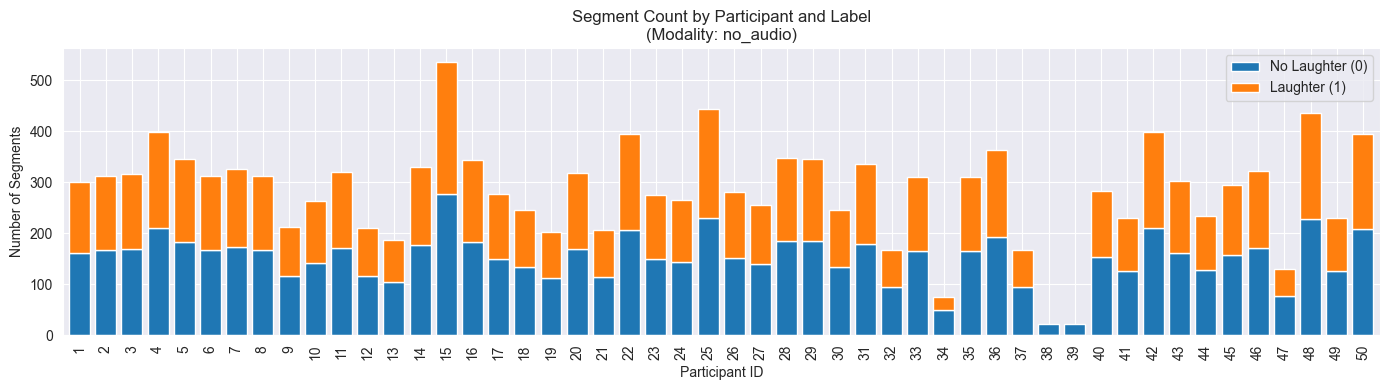

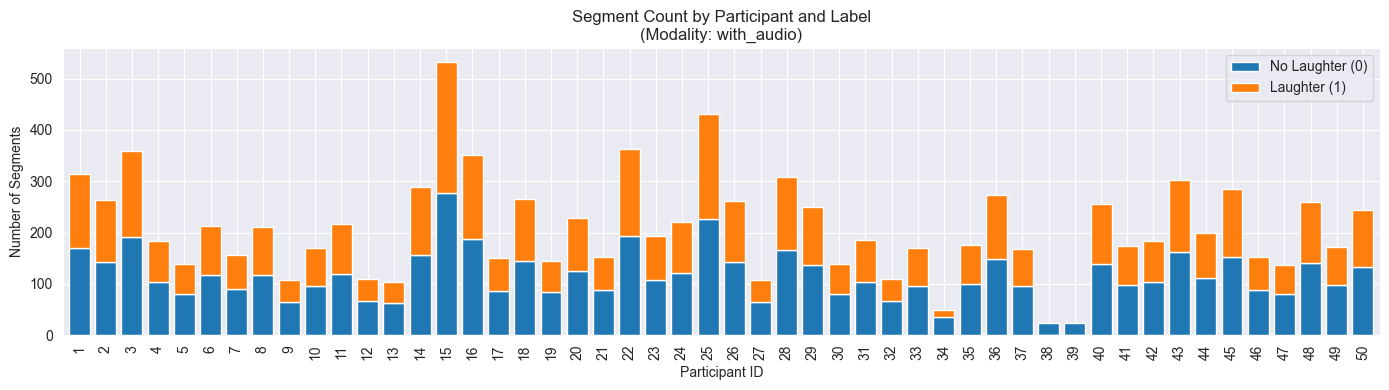

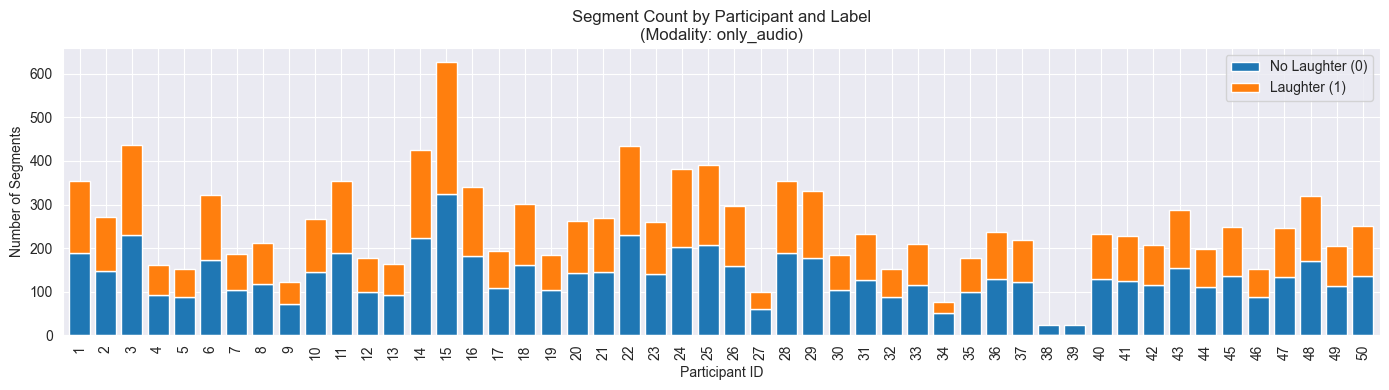

In [21]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load your segmented CSVs into `all_segments`
segments_dir = "./segments_csvs"
paths = glob(os.path.join(segments_dir, "segments_*.csv"))

df_list = []
for path in paths:
    modality = os.path.basename(path).replace("segments_", "").replace(".csv", "")
    df = pd.read_csv(path)
    df["modality"] = modality
    df_list.append(df)

if df_list:
    all_segments = pd.concat(df_list, ignore_index=True)
else:
    raise RuntimeError(f"No segment CSVs found in {segments_dir}")

# 2️⃣ Define the plotting function
def visualize_num_of_segments(participants, labels, title):
    """
    Plots a stacked bar chart of number of no‐laughter (0) vs laughter (1)
    segments per participant.
    """
    df = pd.DataFrame({"participant": participants, "label": labels})
    counts = df.groupby(["participant", "label"]).size().unstack(fill_value=0)
    # Ensure both columns exist
    for col in [0, 1]:
        if col not in counts.columns:
            counts[col] = 0
    counts = counts.sort_index()

    ax = counts.plot(
        kind="bar",
        stacked=True,
        figsize=(14, 4),
        width=0.8
    )
    ax.set_xlabel("Participant ID")
    ax.set_ylabel("Number of Segments")
    ax.set_title(title)
    ax.legend(["No Laughter (0)", "Laughter (1)"], loc="upper right")
    plt.tight_layout()
    plt.show()

# 3️⃣ Generate one plot per modality
for modality in all_segments["modality"].unique():
    subset = all_segments[all_segments["modality"] == modality]
    visualize_num_of_segments(
        subset["participant"],
        subset["label"],
        f"Segment Count by Participant and Label\n(Modality: {modality})"
    )


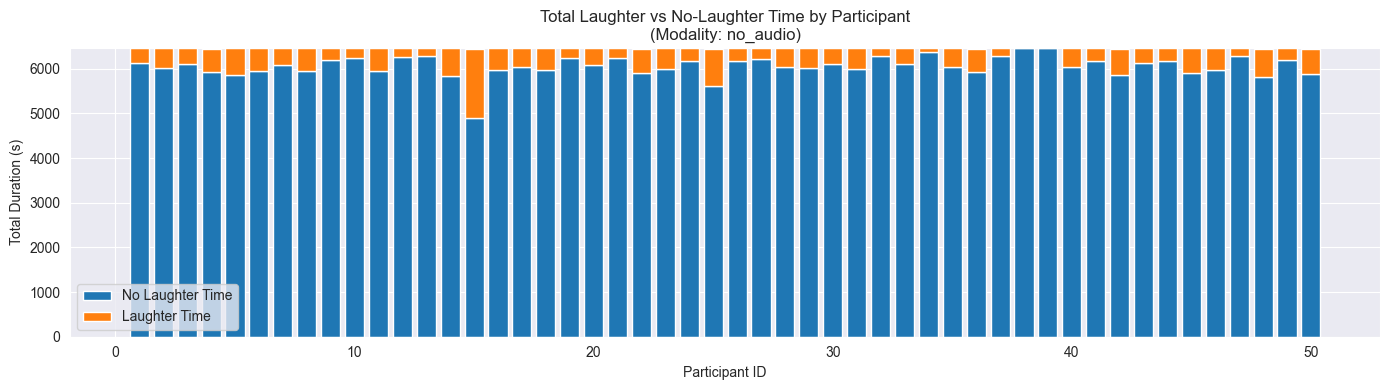

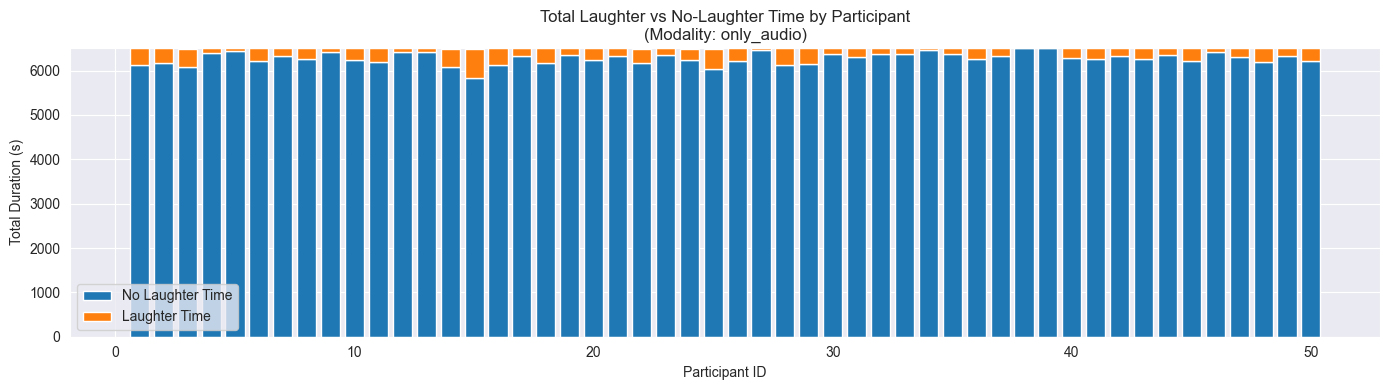

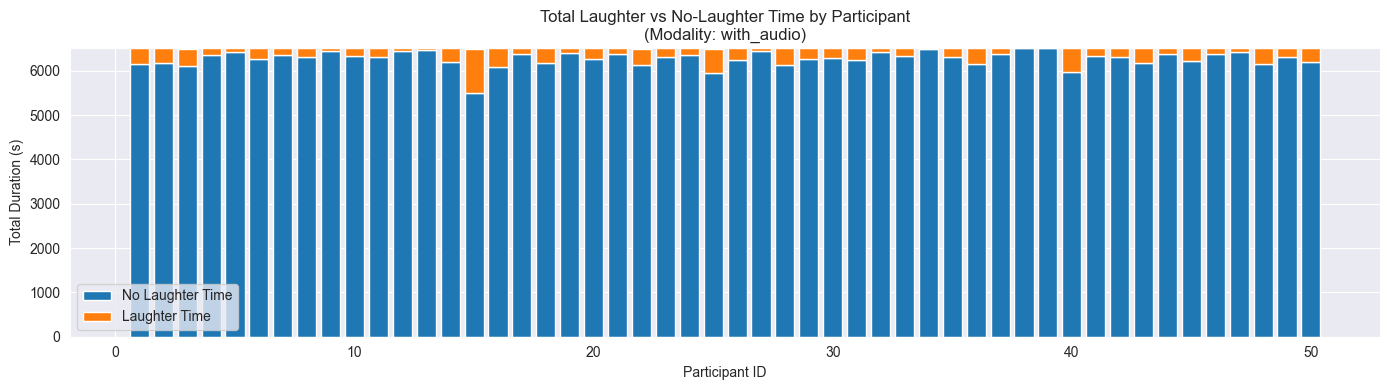

In [13]:
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load all segmented CSVs
segments_dir = "./segments_csvs"
paths = glob(os.path.join(segments_dir, "segments_*.csv"))

df_list = []
for path in paths:
    modality = os.path.basename(path).replace("segments_", "").replace(".csv", "")
    df = pd.read_csv(path)
    df["modality"] = modality
    # compute segment duration
    df["duration"] = df["end_time"] - df["start_time"]
    df_list.append(df)

if not df_list:
    raise RuntimeError(f"No segment CSVs found in {segments_dir}")
all_segments = pd.concat(df_list, ignore_index=True)

# 2️⃣ Sum total duration per participant and label, for each modality
summary = (
    all_segments
    .groupby(["modality", "participant", "label"])["duration"]
    .sum()
    .reset_index()
    .pivot_table(
        index=["modality", "participant"],
        columns="label",
        values="duration",
        fill_value=0
    )
    .rename(columns={0: "no_laughter_time", 1: "laughter_time"})
    .reset_index()
)

# 3️⃣ Plot stacked bar of total durations per participant for each modality
for modality in summary["modality"].unique():
    df_mod = summary[summary["modality"] == modality].sort_values("participant")
    participants = df_mod["participant"].astype(int)
    no_times = df_mod["no_laughter_time"]
    laugh_times = df_mod["laughter_time"]

    plt.figure(figsize=(14, 4))
    plt.bar(participants, no_times, label="No Laughter Time")
    plt.bar(participants, laugh_times, bottom=no_times, label="Laughter Time")
    plt.xlabel("Participant ID")
    plt.ylabel("Total Duration (s)")
    plt.title(f"Total Laughter vs No-Laughter Time by Participant\n(Modality: {modality})")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [18]:
# ─── CONFIG ────────────────────────────────────────────────────────────────
segments_dir = "./segments_csvs"
pkls_dir     = "./pkls"          # folder where your .pkl files live (e.g. "1.pkl", "2.pkl", ...)
output_dir   = "./features_csvs"
os.makedirs(output_dir, exist_ok=True)

# ─── 1. LOAD ALL SEGMENTS ──────────────────────────────────────────────────
seg_paths = glob(os.path.join(segments_dir, "segments_with_audio.csv"))
df_segs = pd.concat([
    pd.read_csv(p).assign(
        modality=os.path.basename(p).split("_")[1].replace(".csv", "")
    )
    for p in seg_paths
], ignore_index=True)

# ─── 2. PRELOAD SIGNALS ────────────────────────────────────────────────────
signals = {}
# We know filtered accel columns end with "_filtered"
filtered_cols = ["accelX_filtered", "accelY_filtered", "accelZ_filtered"]

for pid in sorted(df_segs["participant"].unique()):
    pkl_path = os.path.join(pkls_dir, f"{pid}.pkl")
    if not os.path.exists(pkl_path):
        print(f"⚠️ Skipping participant {pid}: no PKL at {pkl_path}")
        continue
    with open(pkl_path, "rb") as f:
        df_sig = pickle.load(f)
    # Check for 'time' and our accel columns
    if "time" not in df_sig.columns or any(c not in df_sig.columns for c in filtered_cols):
        print(f"⚠️ PKL for p{pid} missing required columns, skipping")
        continue
    signals[pid] = df_sig

#─── 4. EXTRACT FEATURES FOR EVERY EVENT ──────────────────────────────────
records = []
for _, row in df_segs.iterrows():
    pid = row["participant"]
    if pid not in signals:
        continue  # no signal available

    df_sig = signals[pid]
    feats = extract_features_segment(
        df_sig,
        start_t = row["start_time"],
        end_t   = row["end_time"]
    )
    # annotate context
    feats.update({
        "modality":    row["modality"],
        "video_id":    row["video_id"],
        "segment":     row["segment"],
        "participant": pid,
        "label":       row["label"]
    })
    records.append(feats)

# ─── 5. SAVE FEATURES DATASET ─────────────────────────────────────────────
df_features = pd.DataFrame(records)
out_path = os.path.join(output_dir, "features_dataset_with_audio.csv")
df_features.to_csv(out_path, index=False)
print(f"✅ Extracted features for {len(df_features)} segments → {out_path}")

⚠️ Skipping participant 38: no PKL at ./pkls/38.pkl
⚠️ Skipping participant 39: no PKL at ./pkls/39.pkl
✅ Extracted features for 10422 segments → ./features_csvs/features_dataset_with_audio.csv
